In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from numba import jit

In [2]:
plt.plot([0,1])
plt.close()

In [3]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 100

In [4]:

stars = np.fromfile("data/stars.dat",dtype=np.float32)
stars = stars.reshape(stars.shape[0]//3,3)

gas = np.fromfile("data/gas.dat",dtype=np.float32)
gas = gas.reshape(gas.shape[0]//3,3)

In [5]:
def plot3d(*data):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for i in data:
        ax.scatter(i[:,0],i[:,1],i[:,2])
    ax.set_zlabel("z")
    plt.show()

def project(particles,cam_pos,cam_rot,cam_e):
    rot_mat_1 = np.array([[1,0,0],
                          [0,np.cos(cam_rot[0]),np.sin(cam_rot[0])],
                          [0,-np.sin(cam_rot[0]),np.cos(cam_rot[0])]],dtype=np.float32)
    rot_mat_2 = np.array([[np.cos(cam_rot[1]),0,-np.sin(cam_rot[1])],
                          [0,1,0],
                          [np.sin(cam_rot[1]),0,np.cos(cam_rot[1])]],dtype=np.float32)
    rot_mat_3 = np.array([[np.cos(cam_rot[2]),np.sin(cam_rot[2]),0],
                          [-np.sin(cam_rot[2]),np.cos(cam_rot[2]),0],
                          [0,0,1]],dtype=np.float32)

    tmp = (particles-cam_pos)
    new_coords = np.zeros_like(tmp)
    for idx,i in enumerate(tmp):
        new_coords[idx] = (rot_mat_3 @ (rot_mat_2 @ (rot_mat_1 @ i)))
    #new_coords = np.zeros_like(tmp)
    #for i in range(len(tmp)):
        #new_coords[i,0] = rot_mat[0,0] * tmp[i,0] + rot_mat[0,1] * tmp[i,1] + rot_mat[0,2] * tmp[i,2]
        #new_coords[i,1] = rot_mat[1,0] * tmp[i,0] + rot_mat[1,1] * tmp[i,1] + rot_mat[1,2] * tmp[i,2]
        #new_coords[i,2] = rot_mat[2,0] * tmp[i,0] + rot_mat[2,1] * tmp[i,1] + rot_mat[2,2] * tmp[i,2]
    #    new_coords[i,0] = rot_mat[0,0] * tmp[i,0] + rot_mat[1,0] * tmp[i,1] + rot_mat[2,0] * tmp[i,2]
    #    new_coords[i,1] = rot_mat[0,1] * tmp[i,0] + rot_mat[1,1] * tmp[i,1] + rot_mat[2,1] * tmp[i,2]
    #    new_coords[i,2] = rot_mat[0,2] * tmp[i,0] + rot_mat[1,2] * tmp[i,1] + rot_mat[2,2] * tmp[i,2]
    
    #new_coords = out

    bx = (((cam_e[2]/new_coords[:,2])*new_coords[:,0] + cam_e[0]))
    by = (((cam_e[2]/new_coords[:,2])*new_coords[:,1] + cam_e[1]))

    out = np.column_stack((bx,by))
    #out = out[new_coords[:,2] >= 0]
    #out = out[out[:,0] >= 0]
    #out = out[out[:,0] < im_x]
    #out = out[out[:,1] >= 0]
    #out = out[out[:,1] < im_y]
    return out

@jit(nopython=True)
def psf(point,col,r=3,mul=0.1):
    out = np.zeros((2*r+1,2*r+1,3),dtype=np.float32)
    for i in range(2*r+1):
        for j in range(2*r+1):
            tot_dist = (abs(i-(r))/(mul*(r)) + abs(j-(r))/(mul*(r))) + 1
            ratio = 1/(tot_dist*tot_dist+1)
            out[i,j] = col*ratio
    out /= np.sum(out)
    return out * np.sum(col)

In [6]:
@jit(nopython=True)
def get_gas_colors(particles,stars,base_color = np.ones(3,dtype=np.float32)):
    gas_colors = np.zeros_like(particles)
    for i in range(len(particles)):
        gas_particle = particles[i]
        new_stars = stars - gas_particle
        distances = new_stars[:,0]*new_stars[:,0] + new_stars[:,1]*new_stars[:,1] + new_stars[:,2]*new_stars[:,2]
        ratios = 1/(distances)
        gas_colors[i] = np.sum(ratios) * base_color
        #for j in range(len(stars)):
        #    distances = new_stars[:,0]*new_stars[:,0] + new_stars[:,1]*new_stars[:,1] + new_stars[:,2]*new_stars[:,2]
        #    ratios = 1/(distances)
        #    starx = new_stars[j,0]
        #    stary = new_stars[j,1]
        #    starz = new_stars[j,2]
        #    dist2 = starx*starx + stary*stary + starz*starz
        #    ratio = 1/dist2
        #    gas_colors[i] += ratio * base_color
    #gas_colors[:,0] /= np.max(gas_colors[:,0])
    #gas_colors[:,2] /= np.max(gas_colors[:,2])
    return gas_colors

In [7]:
#dists = np.linalg.norm(stars,axis=1)
#plt.scatter(dists,reds,label="red",color="red")
#plt.scatter(dists,blues,label="blue",color="blue")
#plt.show()

In [8]:
@jit(nopython=True)
def fill_grid(grid,z_buff,projected,zs,colors,intensities,r,im_x,im_y,mul=0.1,use_zbuff=False,fill_zbuff=True):
    projected[:,0] += 0.5
    projected[:,0] *= (im_x-1)
    projected[:,1] += 0.5
    projected[:,1] *= (im_y-1)
    colors = colors[projected[:,0] >= 0]
    projected = projected[projected[:,0] >= 0]
    colors = colors[projected[:,0] < im_x]
    projected = projected[projected[:,0] < im_x]
    colors = colors[projected[:,1] >= 0]
    projected = projected[projected[:,1] >= 0]
    colors = colors[projected[:,1] < im_y]
    projected = projected[projected[:,1] < im_y]
    projected = projected.astype(np.int32)
    for i in range(len(projected)):
        if zs[i] >= 0:
            pixel = projected[i]
            point = psf(intensities[i],colors[i],r,mul)
            #point[:] = intensities[i] / (point.shape[0]*point.shape[1])
            left_x = pixel[0]-r
            right_x = pixel[0]+r+1
            left_y = pixel[1]-r
            right_y = pixel[1]+r+1
            point_lx = 0
            point_rx = 2*r+1
            point_ly = 0
            point_ry = 2*r+1
            if (left_x < 0):
                point_lx -= left_x
                left_x = 0
            if (left_y < 0):
                point_ly -= left_y
                left_y = 0
            if (right_x >= im_x):
                point_rx -= right_x - (im_x-1)
                right_x = im_x - 1
            if (right_y >= im_y):
                point_ry -= right_y - (im_y-1)
                right_y = im_y - 1
            #print(left_x,right_x,left_y,right_y,point_lx,point_rx,point_ly,point_ry)
            
            for image_x,psf_x in zip(range(left_x,right_x),range(point_lx,point_rx)):
                for image_y,psf_y in zip(range(left_y,right_y),range(point_ly,point_ry)):
                    #z_buff_val = z_buff[image_x,image_y]
                    #if z_buff_val > zs[i]:
                    #    z_buff[image_x,image_y] = zs[i]
                    #grid[image_y,image_x] = 10
                    #if image_x == pixel[0] and image_y == pixel[1]:
                    #    can_draw = False
                    #    if (zs[i] < z_buff[image_y,image_x]):
                    #        can_draw = True
                    #        if fill_zbuff:
                    #            z_buff[image_y,image_x] = zs[i]
                    #    if (not use_zbuff) or (can_draw):
                    #        grid[image_y,image_x] = point[psf_y,psf_x]
                    #else:
                    grid[image_y,image_x] += point[psf_y,psf_x] #* (1/(grid[image_y,image_x] + 1))
                        #grid[image_y,image_x] /= 2
                    #if use_zbuff and not can_draw:
                    #    
                #grid[left_x:right_x,left_y:right_y] += point[point_lx:point_rx,point_ly:point_ry]
        

In [9]:
dists = np.linalg.norm(stars,axis=1)
reds = 50*(dists*dists)
blues = 1 - 0.02*(dists*dists)
reds[reds > 1] = 1
blues[blues < 0] = 0
reds = reds.reshape(reds.shape[0],1)
blues = blues.reshape(blues.shape[0],1)
star_colors = 0.5 * blues * np.array([1,0,0],dtype=np.float32)  + 0.5 * reds * np.array([0,0,1],dtype=np.float32) + np.ones(3) + np.random.rand(stars.shape[0]*3).reshape(stars.shape[0],3)
star_colors *= ((np.random.rand(stars.shape[0])**3).reshape(stars.shape[0],1)+1)

In [17]:
cam_dist = 1

cam_pos = np.array([0,-(cam_dist*cam_dist)/2,(cam_dist*cam_dist)/2],dtype=np.float32)
cam_rot = np.array([np.pi/2-(np.sqrt(2)/2),0,0],dtype=np.float32)
cam_e = np.array([0,0,1],dtype=np.float32)

im_x = 1024
im_y = 1024

#gas_spread = int((30/256)*im_x)
gas_spread = 3
#gas_spread = 0
#star_spread = int((5/256)*im_y)
star_spread = 3

grid = np.zeros((im_y,im_x,3),dtype=np.float32)
z_buff = np.ones((im_y,im_x),dtype=np.float32) * 1000000

projected = project(gas,cam_pos,cam_rot,cam_e)
gas_colors = get_gas_colors(gas,stars)
#dists = np.linalg.norm(gas,axis=1)
#dists = dists.reshape(dists.shape[0],1)
#gas_colors = np.ones_like(gas) * (1/(dists*dists))

fill_grid(grid,z_buff,projected,gas[:,2],gas_colors,gas_colors[:,0],gas_spread,im_x,im_y,use_zbuff=True,fill_zbuff=True)#,mul=0.1)

projected = project(stars,cam_pos,cam_rot,cam_e)

dists = np.linalg.norm(stars - cam_pos,axis=1)
dists = dists.reshape(dists.shape[0],1)

#new_star_colors = np.ones_like(stars)
grid2 = np.zeros((im_y,im_x,3),dtype=np.float32)
fill_grid(grid2,z_buff,projected,stars[:,2],star_colors * (1/(dists*dists)),1,star_spread,im_x,im_y,use_zbuff=False,fill_zbuff=False)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(int64, int64)
 
There are 22 candidate implementations:
  - Of which 22 did not match due to:
  Overload of function 'getitem': File: <numerous>: Line N/A.
    With argument(s): '(int64, int64)':
   No match.

During: typing of intrinsic-call at /var/folders/26/2tq7_zl56w17rwds1w10r8vr0000gn/T/ipykernel_40118/3770949643.py (19)

File "../../../../var/folders/26/2tq7_zl56w17rwds1w10r8vr0000gn/T/ipykernel_40118/3770949643.py", line 19:
<source missing, REPL/exec in use?>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


186433.83


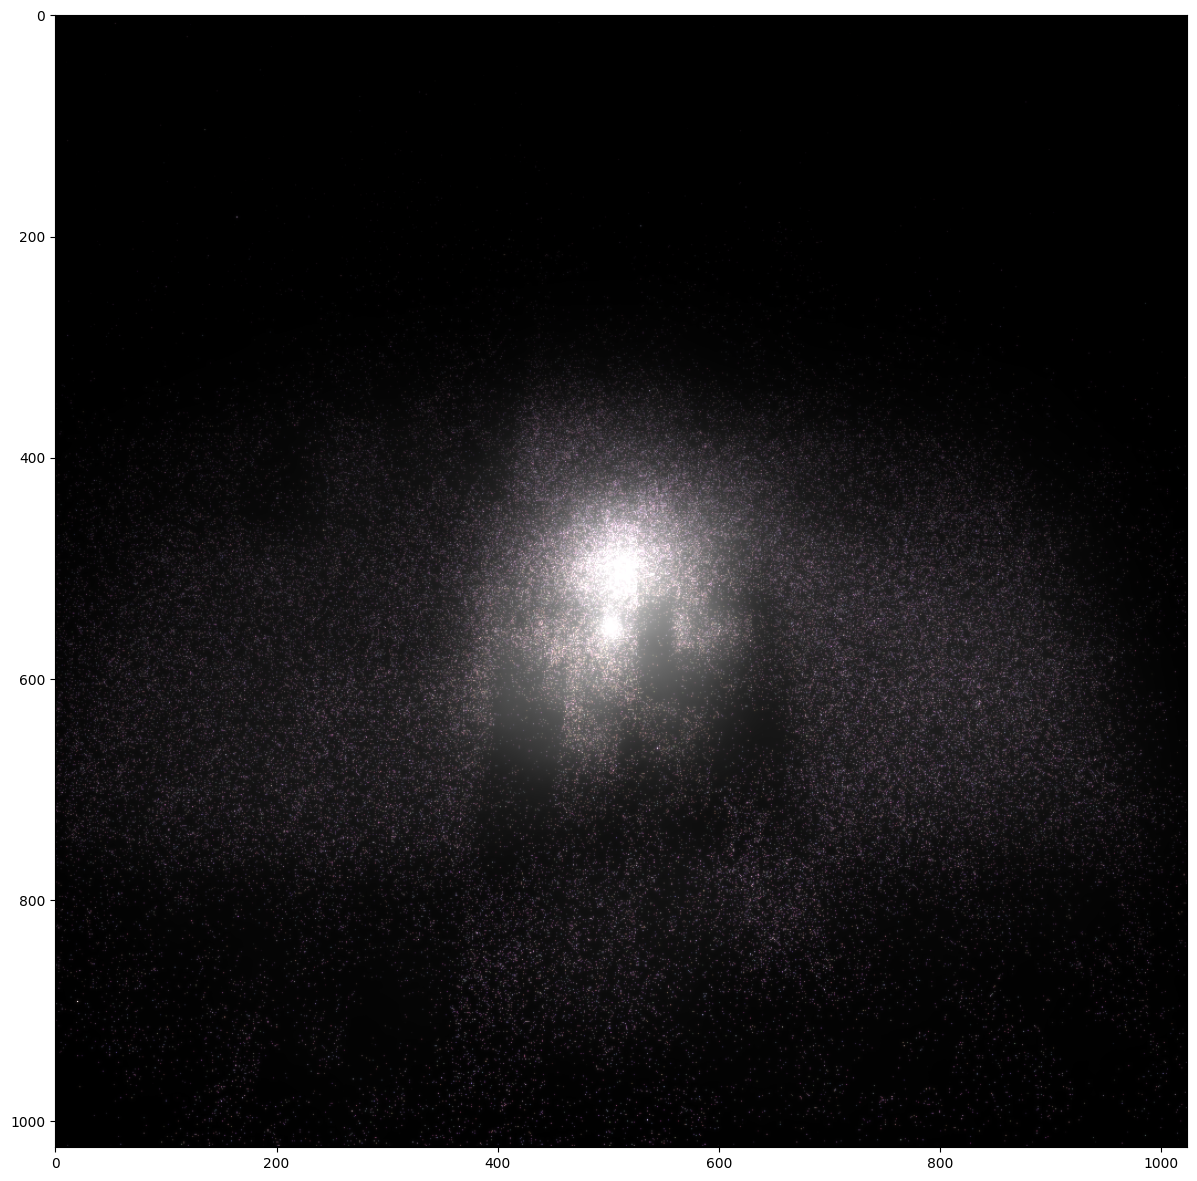

In [16]:
new_grid_1 = np.copy(grid) / np.max(grid)
new_grid_2 = np.copy(grid2) / (100*np.mean(grid2))
new_grid_final = new_grid_1 + new_grid_2*2
#new_grid_final /= np.max(new_grid_final)

print(np.mean(grid))
plt.imshow(new_grid_final)
plt.show()